# Plot the flash product of the GLM
This jupyter notebook shows how to make a sub-region plot of the flash product of the GLM.

Import the GOES package.

In [1]:
import GOES

Search GLM files between **2020-10-19 23:55:00** and **2020-10-20 00:00:00**.

In [2]:
flist=GOES.locate_files('/home/joao/Downloads/GOES-16/GLM/', 'OR_GLM*.nc',
                        '20201019-235500', '20201020-000000')

Reads the files.

In [3]:
ds = GOES.open_mfdataset(flist)

Prints the contents of the files.

In [4]:
print(ds)

<class 'GOES.processing.processing_data.open_mfdataset'>

number files: 15
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20202932355000_e20202932355200_c20202932355223.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20202932355200_e20202932355400_c20202932355427.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20202932355400_e20202932356000_c20202932356026.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20202932356000_e20202932356200_c20202932356226.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20202932356200_e20202932356400_c20202932356427.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20202932356400_e20202932357000_c20202932357027.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20202932357000_e20202932357200_c20202932357223.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20202932357200_e20202932357400_c20202932357428.nc
/home/joao/Downloads/GOES-16/GLM/OR_GLM-L2-LCFA_G16_s20202932357400_e20202932358000_c20202932358025.n

Set the map domain.

In [5]:
domain = [-100.0,-20.0,-40.0,40.0]

Gets longitude and latitude of flash product of GLM.

In [6]:
flash_lon = ds.variable('flash_lon')
flash_lat = ds.variable('flash_lat')

Gets time interval between first and last file.

In [7]:
time_bounds = ds.variable('product_time_bounds')
time_start = time_bounds.data[0,0]
time_end = time_bounds.data[-1,-1]

Creates a regular grid map with **2 km** of spatial resolution.

In [8]:
pix_resol = 2.0
gridmap_LonCor, gridmap_LatCor = GOES.create_gridmap(domain, PixResol=pix_resol)

Accumulate flash in the gridmap. Keep in mind that **gridmap_LonCor** and **gridmap_LatCor** are the corners of the pixels where the lightnings will accumulate. <br>
**Notice:** If your version of GOES package not have the **GOES.accumulate_in_gridmap** function, then you must update the package to the latest version.

In [9]:
dens = GOES.accumulate_in_gridmap(flash_lon, flash_lat, gridmap_LonCor, gridmap_LatCor)

    There are 5933 lightnings inside gridmap
    processing 100%


Gets information about data.

In [10]:
sat = ds.attribute('platform_ID')[0]

Sets product name.

In [11]:
name = 'Flash density'

Creates a custom color palette using the [custom_color_palette](https://github.com/joaohenry23/custom_color_palette) package.

In [12]:
# import packages
import custom_color_palette as ccp

# set the colors of the custom palette
paleta1 = [['black'], [0,1]]
paleta2 = [['yellow','darkorange','red','firebrick'], [1,5,10,15,20,25,30,40,50,60,70]]

# pass parameters to the creates_palette module
cmap, cmticks, norm, bounds = ccp.creates_palette([paleta1, paleta2], extend='max',
                                                  lower_color='black', upper_color='maroon')

# set ticks for colorbar
ticks = cmticks

Creates plot.

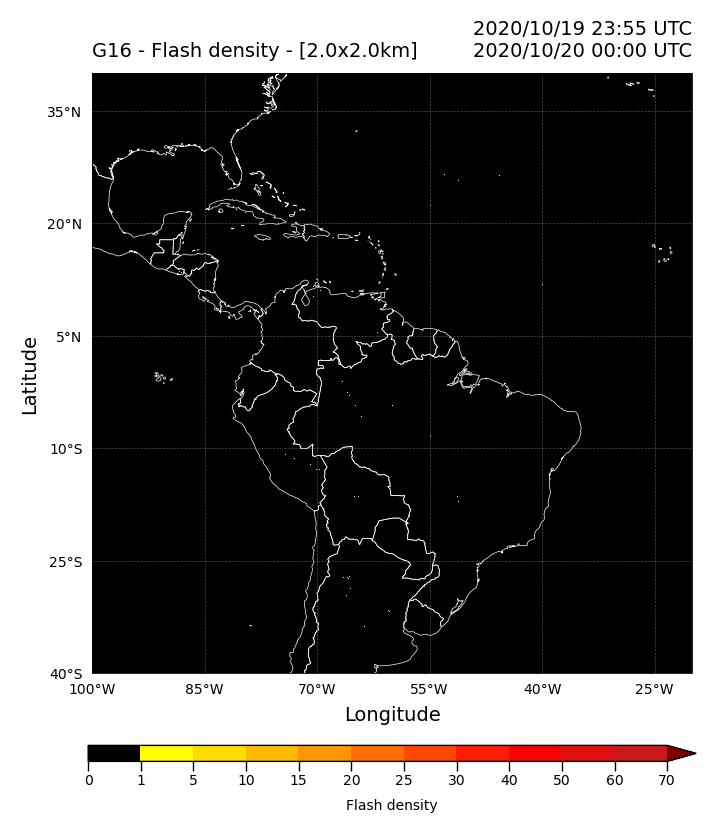

In [13]:
# import packages
import numpy as np
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# calculates the central longitude of the plot
lon_cen = 360.0+(domain[0]+domain[1])/2.0

# creates the figure
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(lon_cen))
ax.outline_patch.set_linewidth(0.3)

# add the geographic boundaries
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='white', linewidth=0.25)

# plot the data
img = ax.pcolormesh(gridmap_LonCor.data, gridmap_LatCor.data, dens.data, cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

# add the colorbar
cb = plt.colorbar(img, ticks=ticks, extend='max', orientation='horizontal',
                  cax=fig.add_axes([0.12, 0.05, 0.76, 0.02]))
cb.ax.tick_params(labelsize=5, labelcolor='black', width=0.5, direction='out', pad=1.0)
cb.set_label(label='{}'.format(name), size=5, color='black', weight='normal')
cb.outline.set_linewidth(0.5)

# set the title
ax.set_title('{} - {} - [{}x{}km]'.format(sat, name, pix_resol, pix_resol), fontsize=7, loc='left')
ax.set_title('{:%Y/%m/%d %H:%M UTC}\n{:%Y/%m/%d %H:%M UTC}'.format(time_start, time_end),
             fontsize=7, loc='right')

# Sets X axis characteristics
dx = 15
xticks = np.arange(domain[0], domain[1]+dx, dx)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(dateline_direction_label=True))
ax.set_xlabel('Longitude', color='black', fontsize=7, labelpad=3.0)

# Sets Y axis characteristics
dy = 15
yticks = np.arange(domain[2], domain[3]+dy, dy)
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_ylabel('Latitude', color='black', fontsize=7, labelpad=3.0)

# Sets tick characteristics
ax.tick_params(left=True, right=True, bottom=True, top=True,
               labelleft=True, labelright=False, labelbottom=True, labeltop=False,
               length=0.0, width=0.05, labelsize=5.0, labelcolor='black')

# Sets grid characteristics
ax.gridlines(xlocs=xticks, ylocs=yticks, alpha=0.6, color='gray',
             draw_labels=False, linewidth=0.25, linestyle='--')

# set the map limits
ax.set_extent([domain[0]+360.0, domain[1]+360.0, domain[2], domain[3]], crs=ccrs.PlateCarree())

plt.show()